# Building AI for BlackJack Game

This notebook is for explorartion purposes. I keep this notebook as a journal.

- This idea has been started with a conversation that I have made with my nephew. He asked me if we could build an AI agent that plays the best moves for blackjack. After some arguing on the topic, we have agreed that it would be overkill to train a deep net. Hence there were already best posible moves avaible. However this table only keeps the best action to play in a total matrix of player and dealer. So we have agreed to at least to construct a q-value table via reinforcement learning. We are expecting to construct a q-value table that will consists of the best move to to make (Hit,Double,Stand) in percentages. Our intension is to keep it simple so we will not implement the full rrules of the game. We will consider Ace as 1 not 11. I've learned that this is called hard totals. The avaible best moves are as follows:

![Best Action Table](best_moves_in_hard_totals.jpeg)

- So our plan is to put the percentages of each action for each state. (Q-Values)
- We are also aware of [this](https://towardsdatascience.com/reinforcement-learning-solving-blackjack-5e31a7fb371f) page. We may check it out in the future. But for learning purposes I will check it out if I geet stuck of my own.

28.05.2020

- I start right away coding the environment, I need to remember my other projects. First I will copy my abstract methods here.
- So while checking my other [projects](https://github.com/hakanonal/geodashml) I need to decide the dimensions of the table. 
    - 1 dimension is for the playes's total card.
    - 1 dimension is for the dealers open card.
    - and one dimension is for the action. which is for simplicity Hit or Stand.
- So the shape of the table is (21,10,2)
- Ok very simple q-tabled agent has been completed.
- action space 0 is stand and 1 is hit
- Ok I am currentlly stuck at play method of environment class. I need to think thourgh how should construct reward. Since getting the hihgest number would not be promoted. But I need to give reward to get more that dealer.

31.05.2020

- I have started to read [this](https://towardsdatascience.com/reinforcement-learning-solving-blackjack-5e31a7fb371f)
- I have completed reding. My First note is that in conclusion the wins and lose counts are almost same. I need to underrstand the reward mecanism better to make comments on this. 
- Writer sugested 3 addtional improvements on his code which I bealive I can apply fitst two on them. 1-do more episodes, 2-try different learning and exploration rate.
- Writer implemented the ace or 1 succesfully. I will notte that for later use.
- I have also relized that writer structured tthe q-table as 2 dim array and first dim keeps tuple as index, which is very convinient to easily expand the features of the state paramters. So I have changes it
- In terrms of reward, this example did not updated the q-table in every action but collects all the actions in a list forr every 1 episode and then loops though backwards to update. Which I think I am going to use the same tactic here. 
- I will continue later to adapt to play actions till end of the game and calculate and update the reward afterwards for each episode.

01.06.2020

- I have continues on developing agent and environment
- I have also tested my first run and startd to correct the syntax and other types of error.
- I have seen that if I convert the q-table numpy array to dictionary I understant that I need to change the state into tuple.
- However tuple values can not be updated and state must be updated all the time. 
- So I have converted the state also to dictionary.
- It seems that I am on correct path. Now since I have converted q-table to dictionary I need to init all possible values. otherwise I get the key error.
- I have implemented a getq function to check if the key is exists when accesing the q-value, if there is no q value I initilize as 0.
- Dude it is unbeliavable fast did I somtething wrong?
- I am turning the beast on, trying different config parameters.
- However, my intension is to detaili debug if the logic is working correctlly.
- I have seen in the article that the q-table has been stored the file using the pickle module. So I also used that.

In [ ]:
import numpy as np
import random
import pickle


class agent:

    def __init__(self,discount,exploration_rate,decay_factor, learning_rate):
        self.discount = discount # How much we appreciate future reward over current
        self.exploration_rate = exploration_rate # Initial exploration rate
        self.decay_factor = decay_factor
        self.learning_rate = learning_rate
        self.q_table = {}
        
    def get_next_action(self, state):
        if random.random() < self.exploration_rate: # Explore (gamble) or exploit (greedy)
            return self.random_action()
        else:
            return self.greedy_action(state)

    def greedy_action(self, state):
        return np.argmax(self.getQ(state))
    def random_action(self):
        return random.random() > 0.5

    def getQ(self,state):
        player_sum = state['player_sum']
        dealer_sum = state['dealer_sum']
        if (player_sum,dealer_sum) not in self.q_table:
            self.q_table[(player_sum,dealer_sum)] = [0,0]
        return self.q_table[(player_sum,dealer_sum)]

    def train(self, old_state, new_state, action, reward):
        
        old_state_prediction = self.getQ(old_state)[action]
        new_state_prediction = self.getQ(new_state)

        old_state_prediction = ((1-self.learning_rate) * old_state_prediction) + (self.learning_rate * (reward + self.discount * np.amax(new_state_prediction)))

        self.q_table[(old_state['player_sum'],old_state['dealer_sum'])][action] = old_state_prediction
        return old_state_prediction

    def update(self, old_state, new_state, action, reward):        
        reward = self.train(old_state, new_state, action, reward)
        self.exploration_rate *= self.decay_factor
        return reward

    def save(self, file="policy"):
        fw = open(file, 'wb')
        pickle.dump(self.q_table, fw)
        fw.close()

    def load(self, file="policy"):
        fr = open(file, 'rb')
        self.q_table = pickle.load(fr)
        fr.close()        


In [ ]:
import random

class environment:

    def __init__(self, config=None):

        self.config = config
        self.agent = agent(
            discount=self.config['discount'],
            exploration_rate=self.config['exploration_rate'],
            decay_factor=self.config['decay_factor'],
            learning_rate=self.config['learning_rate']
            )
        self.initGame()
        self.metrics = {
            'tot_win' : 0,
            'tot_draw' : 0,
            'tot_lose': 0,
        }

    def initGame(self):
        self.state = {'player_sum':0,'dealer_sum':0} 
        self.state['player_sum'] += self.hit()
        self.state['player_sum'] += self.hit()
        self.state['dealer_sum'] += self.hit()
        self.actions_played = []

    def start(self):
        for episode in range(1,self.config['episode']+1):
            self.initGame()
            #player turn
            while True:
                action_to_play = self.agent.get_next_action(self.state)
                new_state, ended = self.play(action_to_play)
                self.actions_played.append((self.state,new_state,action_to_play))
                self.debug1(episode,self.state,new_state,action_to_play)
                self.state = new_state
                if ended:
                    break

            #dealer turn
            while True:
                new_state, ended = self.playDealer()
                self.debug1(episode,self.state,new_state,-1)
                self.state = new_state
                if ended:
                    break

            #q-tatble update backpropogation
            reward = self.findWinner()
            if reward == 1:
                self.metrics['tot_win'] += 1
                self.metrics['avg_win'] = self.metrics['tot_win'] / episode
            if reward == 0:
                self.metrics['tot_draw'] += 1
                self.metrics['avg_draw'] = self.metrics['tot_draw'] / episode
            if reward == -1:
                self.metrics['tot_lose'] += 1
                self.metrics['avg_lose'] = self.metrics['tot_lose'] / episode
            for old_state,new_state,action in reversed(self.actions_played):
                new_reward = self.agent.update(old_state,new_state,action,reward)
                self.debug2(episode,old_state,new_state,action,reward,new_reward)
                reward = new_reward

    def hit(self):
        return random.randint(1,10)

    def play(self,action):
        new_state = self.state.copy()
        ended = False
        if action:
            new_state['player_sum'] += self.hit()
        else:
            ended = True
        if new_state['player_sum'] > 21:
            ended = True
        return new_state, ended
        
    def playDealer(self):
        new_state = self.state.copy()
        ended = False
        new_state['dealer_sum'] += self.hit()
        if new_state['dealer_sum'] >= 17:
            ended = True
        return new_state, ended
        
    def findWinner(self):
        # player 1 | draw 0 | dealer -1
        winner = 0
        if self.state['player_sum'] > 21:
            if self.state['dealer_sum'] > 21:
                winner = 0
            else:
                winner = -1
        else:
            if self.state['dealer_sum'] > 21:
                winner = 1
            else:
                if self.state['player_sum'] < self.state['dealer_sum']:
                    winner = -1
                elif self.state['player_sum'] > self.state['dealer_sum']:
                    winner = 1
                else:
                    winner = 0
        return winner
    
    def debug1(self,episode,old_state,new_state,action):
        if(self.config['debug']):
            print("%d = %s -> %s -> %s"%(episode,old_state,action,new_state))
            input("continue?")

    def debug2(self,episode,old_state,new_state,action,old_reward,new_reward):
        if(self.config['debug']):
            print("%d = %s -> %s -> %s | %s->%s"%(episode,old_state,action,new_state,old_reward,new_reward))
            input("continue?")


In [ ]:
config = {
    'discount': 0.5,
    'exploration_rate':0.5,
    'decay_factor':0.9999,
    'learning_rate':0.0001,
    'episode':1000000,
    'debug' : 0,
}

e = environment(config=config)
e.start()
e.agent.save()
e.metrics

01.06.2020

- let's plot tthe q-table and see it is going to be mean something. To do that I will add a method into agent class that converts the q-table dictionary to multi dim numpy array.
- Well I have converted the qtable into numpy array. I have omitted the values that is not being represented for valid total. Suprasinglly all values are zero. I need to debug better if rewarrding mechanism is working good.
- I have added a debug method to see turns plays and steps are working fine. it seems ok. I will heck reward calcıulation also.
- Ok I think I have found the problem, in backpropogation in every update instead of using the old_state I have always used the self.state whichnis the last state of the game which is wrong.
- When I trained this way I have increase the win rate tto 40%, On the other hand draw position is also increased
- When I plot the q-values I have a very non-meaningful graph. I need to fins a better way to present this data better.

In [20]:
e.agent.load()
e.agent.q_table

{(17, 2): [-0.16639612593021053, -0.16501925636239315],
 (13, 7): [-0.04740934570922169, 0.003475717908089998],
 (8, 4): [-0.03246042127823353, -0.032567481054749055],
 (3, 4): [-0.00219726759956068, -0.002149258158371354],
 (14, 7): [-0.07767365125693704, -0.04242183340470786],
 (20, 7): [0.6214658674050376, -0.001298247022054118],
 (7, 4): [-0.0314229289765365, -0.03142789222790722],
 (5, 6): [-0.009553702117972301, -0.009505577680225965],
 (17, 4): [-0.16041830812634622, -0.15638304927595226],
 (15, 4): [-0.13026574346563272, -0.1285689745199958],
 (21, 4): [0.6838875337314179, -0.000599780051991901],
 (13, 4): [-0.05557207847949556, -0.03209891399674031],
 (5, 4): [-0.012514742286310266, -0.012487149428844624],
 (13, 2): [-0.061240985373337345, -0.03834806781594694],
 (14, 9): [-0.09294219957804654, -0.06931689823178995],
 (10, 9): [-0.0008995325236511208, 0.03551134072516221],
 (21, 2): [0.7092194316047563, -0.0004998100339965002],
 (16, 4): [-0.14908770704512175, -0.1443300589565

In [39]:
X = []
Y = []
Z = [] 
for state,alist in e.agent.q_table.items():
    if(state[0] > 21):
        continue
    if(state[1] > 10):
        continue
    X.append([state[0],alist[0]])
    X.append([state[0],alist[1]])
    Y.append([state[1],alist[0]])
    Y.append([state[1],alist[1]])
    Z.append([0,alist[0]])
    Z.append([1,alist[1]])

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

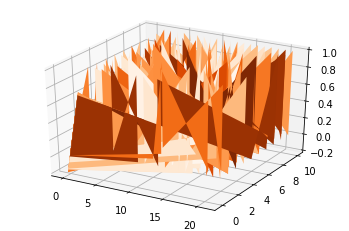

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z,cmap="Oranges")